Settings: Sub Gridding
======================

This example demonstrates how to change the sub-grid used by a parametric `LightProfile` to compute the surface
brightness of every image-pixel, whereby a higher sub-grid resolution better oversamples the image of the light profile
so as to provide a more accurate model of its image.

**Benefit**: Higher level of sub-gridding provide a more accurate estimate of the surface brightness in every image-pixel.
**Downside**: Higher levels of sub-gridding require longer calculations and higher memory usage.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Settings Specific Code__

To customize the sub-grid used by the model-fit, we create a `SettingsImaging` object and specify that the 
`sub_size=4`. 

This increases the sub grid size of the `Grid2D` used to evaluate the lens galaxy and source galaxy `LightProfiles` 
from the default value of 2 to 4.

In [2]:
settings_imaging = al.SettingsImaging(grid_class=al.Grid2D, sub_size=4)

__Dataset + Masking__ 

For this sub-grid to be used in the model-fit, we must pass the `settings_imaging` to the `Imaging` object,
which will be created using a `Grid2D` with a `sub-size value` of 4 (instead of the default of 2).

In [3]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

imaging = imaging.apply_settings(
    settings=settings_imaging
)  # <----- The `SettingsImaging` above is used here!

__Masking__

The model-fit requires a `Mask2D` defining the regions of the image we fit the lens model to the data, which we define
and use to set up the `Imaging` object that the lens model fits.

In [4]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

__Model + Search + Analysis__ 

The code below performs the normal steps to set up a model-fit. We omit comments of this code as you should be 
familiar with it and it is not specific to this example!

In [5]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

search = af.DynestyStatic(
    path_prefix=path.join("imaging", "settings"), name="sub_grid_size"
)

analysis = al.AnalysisImaging(dataset=imaging)

__Model-Fit__

We can now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear
search to find which models fit the data with the highest likelihood.

Because the `AnalysisImaging` was passed a `Imaging` with a `sub_size=4` it uses a higher level of sub-gridding
to fit each model `LightProfile` to the data.

In [6]:
result = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  9.69it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Result__

We can confirm that the `Result`'s grid used a sub-size of 4.

4


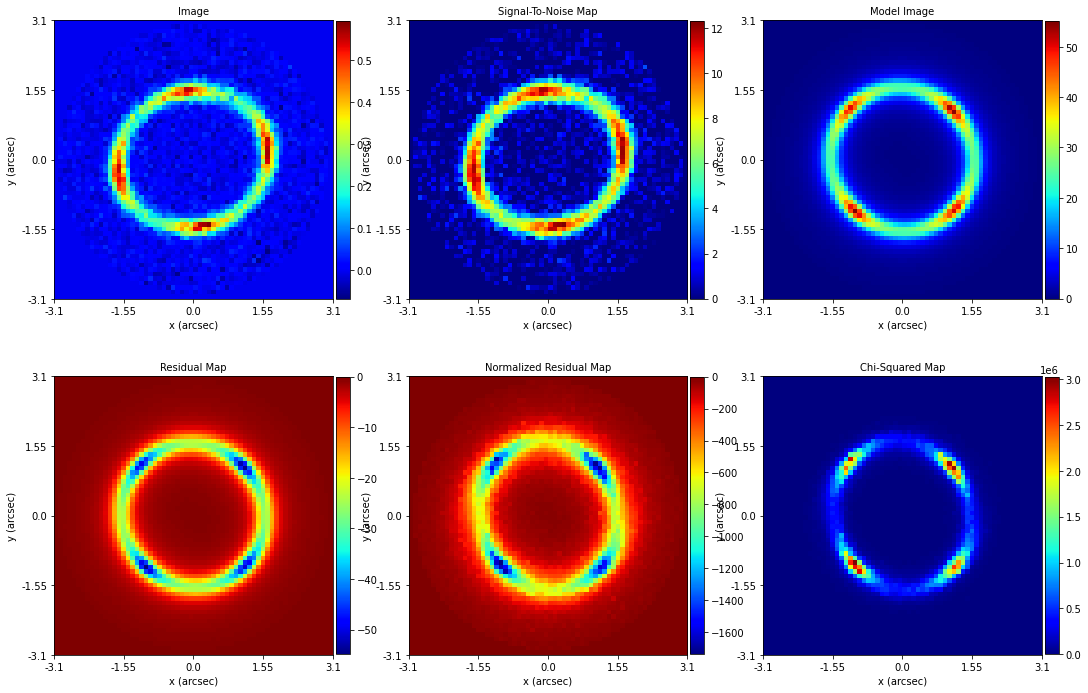

In [7]:
print(result.grid.sub_size)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

Finish.